In [47]:
from scraper.scraper import TokenScraper, MinterTransferScraper
from blockchain.token import Token
from blockchain.account import AccountNode

import networkx as nx
import matplotlib.pyplot as plt
import json
from pathlib import Path
import os

In [48]:
# this function recursively builds a directed graph (diGraph) from our root node
# it takes an accountnode and a networkx digraph, then adds edges for all children
# in the style "parent -> child"
def build_graph_from_node(node: AccountNode, graph: nx.DiGraph):
    # for each child of the current node, add an edge in the digraph
    for child in node.children:
        graph.add_edge(node.address, child.address)
        build_graph_from_node(child, graph)

In [49]:
# this function plots the graph from the root node
# it uses kamada-kawai layout for positions
# the root node will be colored red, others skyblue
# we also show label "ROOT" on the minter node and some top-degree nodes
def plot_graph_from_root(root: AccountNode, title: str = "Token Transfer Graph"):
    # create an empty DiGraph
    G = nx.DiGraph()
    # build the graph structure from our root
    build_graph_from_node(root, G)

    # get a list of all nodes and compute positions
    node_list = list(G.nodes())
    pos = nx.kamada_kawai_layout(G)

    # color for all nodes is skyblue; root is red
    node_colors = ["skyblue"] * len(node_list)
    if root.address in node_list:
        idx = node_list.index(root.address)
        node_colors[idx] = "red"

    # we optionally label only the root + a few nodes with the highest degree
    labels = {root.address: "ROOT"}
    top_n = 10
    degrees = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    top_nodes = [addr for (addr, deg) in degrees[:top_n]]
    for node in top_nodes:
        if node != root.address:
            labels[node] = node[:6] + "..."

    # we plot the graph
    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(G, pos, nodelist=node_list, node_size=100, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=7, width=0.5, alpha=0.6, edge_color="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [50]:
# this callback is called at each step of scraping
# depth: current step
# root: the updated root node
# total_nodes_count: total number of unique nodes so far
# frontier_count: number of new addresses found on this step
# token: the token object
#
# it also plots the current graph plus a chart of how nodes and edges evolve over steps
def step_callback(depth: int, root: AccountNode, total_nodes_count: int, frontier_count: int, token: Token):
    print(f"[CALLBACK] Step={depth}, total_nodes={total_nodes_count}, frontier={frontier_count}")

    # first, we build a DiGraph so we can count edges easily
    G = nx.DiGraph()
    build_graph_from_node(root, G)
    edge_count = G.number_of_edges()

    # we store the history in function attributes
    # to plot the cumulative data: steps, node counts, edge counts
    if not hasattr(step_callback, "history"):
        step_callback.history = {
            "steps": [],
            "nodes": [],
            "edges": []
        }

    step_callback.history["steps"].append(depth)
    step_callback.history["nodes"].append(total_nodes_count)
    step_callback.history["edges"].append(edge_count)

    # now we plot the current transfer graph
    plot_graph_from_root(
        root,
        title=f"Graph after step={depth}, total_nodes={total_nodes_count}, edges={edge_count}"
    )

    # then we plot how nodes and edges changed over the steps
    steps = step_callback.history["steps"]
    node_counts = step_callback.history["nodes"]
    edge_counts = step_callback.history["edges"]

    plt.figure(figsize=(8, 5))
    plt.plot(steps, node_counts, marker='o', label='Nodes')
    plt.plot(steps, edge_counts, marker='o', label='Edges')
    plt.title("Nodes & Edges Over Steps")
    plt.xlabel("Step")
    plt.ylabel("Count")
    plt.grid(True)
    plt.legend()
    plt.show()

In [51]:
# this function returns a DiGraph after fully building from the root
def get_final_nx_graph(root):
    G = nx.DiGraph()
    build_graph_from_node(root, G)
    return G

### Function computes complex-network metrics on the final graph
- each metric can help us understand certain structural aspects of the transaction graph:
- degree distribution: how many connections each node has
- clustering: how likely nodes in a neighborhood are interconnected
- average shortest path: how many steps on average it takes to go from one node to another
- connected components: how the graph splits into subgraphs
- betweenness/closeness (centralities): how important or "central" a node is in connecting others
- assortativity: do high-degree nodes link to other high-degree nodes or not
- rich-club coefficient: do the "rich" (high-degree) nodes form tightly-knit subgraphs or not

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

def analyze_final_graph(root):
    # 1) build the full DiGraph from the root
    G = get_final_nx_graph(root)

    print(f"Total nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

    # 2) gather degree data
    in_degs = [deg for _, deg in G.in_degree()]
    out_degs = [deg for _, deg in G.out_degree()]
    avg_in  = sum(in_degs) / len(in_degs) if in_degs else 0
    avg_out = sum(out_degs) / len(out_degs) if out_degs else 0
    print(f"Average in-degree:  {avg_in:.2f}")
    print(f"Average out-degree: {avg_out:.2f}")

    # 2a) plot in-degree distribution (log scale on y)
    plt.figure(figsize=(8, 5))
    plt.hist(
        in_degs,
        bins=100,
        color="cornflowerblue",
        alpha=0.8,
        edgecolor="white",
        log=True
    )
    plt.title("In-degree distribution (log scale on Y)")
    plt.xlabel("In-degree")
    plt.ylabel("Count (log scale)")
    plt.grid(True)
    plt.show()

    # 2b) plot out-degree distribution (log scale on y)
    plt.figure(figsize=(8, 5))
    plt.hist(
        out_degs,
        bins=100,
        color="lightsteelblue",
        alpha=0.8,
        edgecolor="white",
        log=True
    )
    plt.title("Out-degree distribution (log scale on Y)")
    plt.xlabel("Out-degree")
    plt.ylabel("Count (log scale)")
    plt.grid(True)
    plt.show()

    # 3) clustering coefficient (undirected version)
    undirected_G = G.to_undirected()
    avg_clustering = nx.average_clustering(undirected_G)
    print(f"Average clustering (undirected): {avg_clustering:.4f}")

    # 4) connected components + average shortest path in the largest WCC
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    subG = G.subgraph(largest_wcc).copy()
    subG_und = subG.to_undirected()

    if nx.is_connected(subG_und):
        spl = nx.average_shortest_path_length(subG_und)
        print(f"Avg shortest path length (largest WCC, undirected): {spl:.4f}")
    else:
        print("Largest WCC is not fully connected even in undirected sense.")

    # 4a) print stats on strongly and weakly connected components
    scc = list(nx.strongly_connected_components(G))
    scc_sizes = [len(c) for c in scc]
    wcc = list(nx.weakly_connected_components(G))
    wcc_sizes = [len(c) for c in wcc]
    print(f"Number of strongly connected components: {len(scc_sizes)}")
    print(f"Largest SCC size: {max(scc_sizes) if scc_sizes else 0}")
    print(f"Number of weakly connected components: {len(wcc_sizes)}")
    print(f"Largest WCC size: {max(wcc_sizes) if wcc_sizes else 0}")

    # 5) centralities: betweenness & closeness
    print("Computing betweenness_centrality (might be slow for large graphs).")
    bc = nx.betweenness_centrality(G, k=None, normalized=True)
    print("Computing closeness_centrality.")
    cc = nx.closeness_centrality(G)

    # 5a) top-5 nodes by betweenness and closeness
    top_betw = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:5]
    top_close = sorted(cc.items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top-5 by betweenness_centrality:", top_betw)
    print("Top-5 by closeness_centrality:  ", top_close)

    # 5b) distribution of betweenness
    bc_vals = list(bc.values())
    plt.figure(figsize=(8, 5))
    plt.hist(
        bc_vals,
        bins=50,
        color="plum",
        alpha=0.8,
        edgecolor="white",
        log=True
    )
    plt.title("Betweenness centrality distribution (log scale on Y)")
    plt.xlabel("Betweenness centrality")
    plt.ylabel("Count (log scale)")
    plt.grid(True)
    plt.show()

    # 5c) distribution of closeness
    cc_vals = list(cc.values())
    plt.figure(figsize=(8, 5))
    plt.hist(
        cc_vals,
        bins=50,
        color="thistle",
        alpha=0.8,
        edgecolor="white",
        log=True
    )
    plt.title("Closeness centrality distribution (log scale on Y)")
    plt.xlabel("Closeness centrality")
    plt.ylabel("Count (log scale)")
    plt.grid(True)
    plt.show()

    # 6) assortativity (out->in)
    r_inout = nx.degree_pearson_correlation_coefficient(G, x='out', y='in')
    print(f"Degree Pearson correlation (out->in) = {r_inout:.4f}")

    # 7) rich-club coefficient (un-normalized)
    rc = nx.rich_club_coefficient(undirected_G, normalized=False)
    sorted_k = sorted(rc.keys())
    print("Rich-club coefficient (un-normalized):")
    for k in sorted_k[:10]:
        print(f" k={k}: phi={rc[k]}")


In [53]:
# now let's define the token address and the max steps
TOKEN_ADDRESS = "BCAHqsUhVMgdeFR5noHVFnoTidrfd4uHYwgEBUTkJX5"
MAX_STEPS = 4

In [54]:
# we create a folder to store step_{depth}.json files
steps_folder = Path("data") / TOKEN_ADDRESS
steps_folder.mkdir(parents=True, exist_ok=True)

In [55]:
# we scrape the token data, then run the step-by-step transfer scraper
token_obj = TokenScraper(Token(address=TOKEN_ADDRESS)).get_token_data()
scraper = MinterTransferScraper(token=token_obj, max_steps=MAX_STEPS)


Got minting data for token CYBRO


Loaded existing step_0.json => root has 1 node(s).
[SKIP] step_1.json found => skip scraping step 1
[CALLBACK] Step=1, total_nodes=101, frontier=100


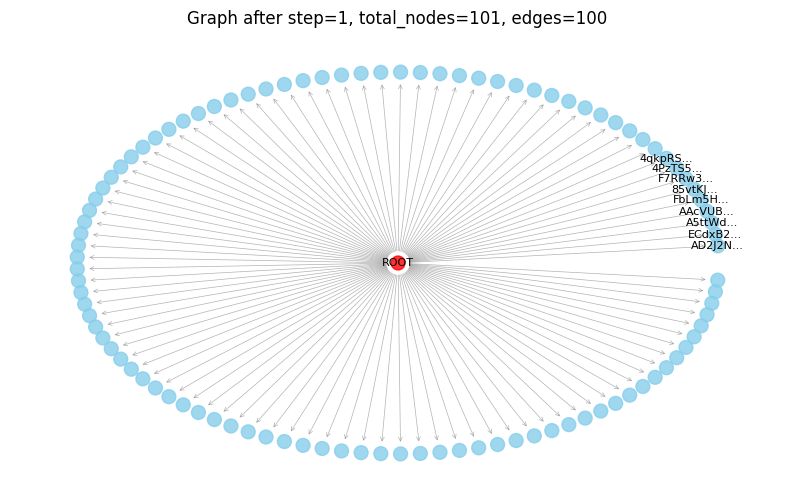

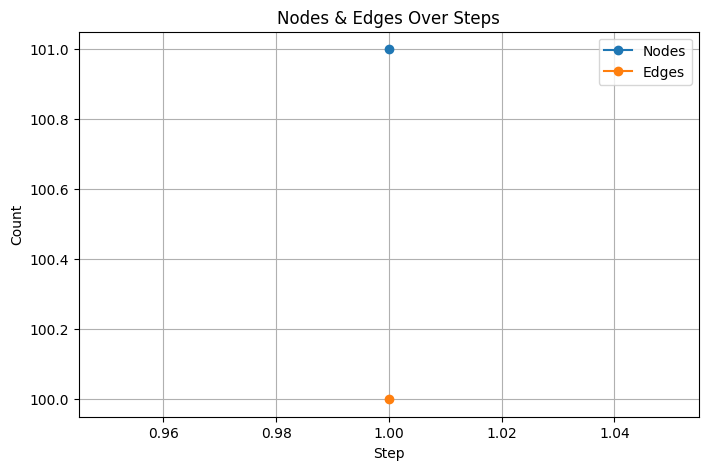

[SKIP] step_2.json found => skip scraping step 2
[CALLBACK] Step=2, total_nodes=101, frontier=21


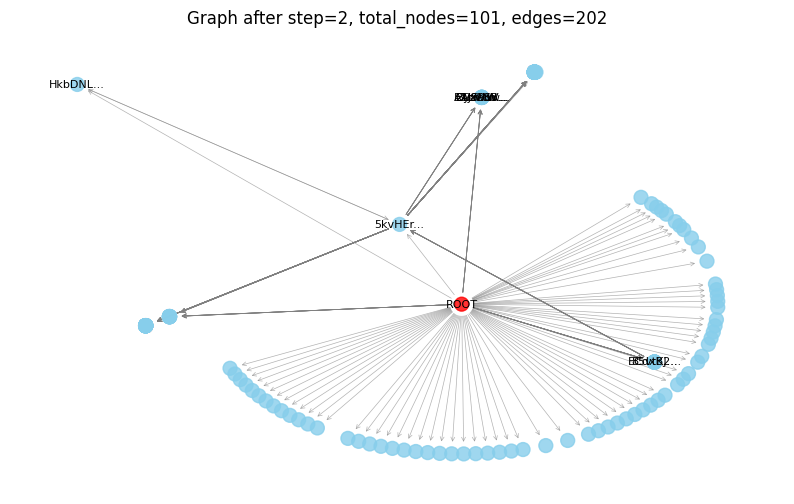

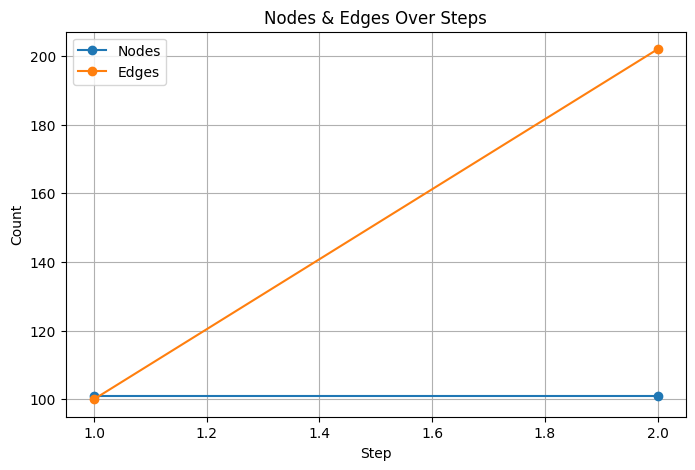

[SKIP] step_3.json found => skip scraping step 3
[CALLBACK] Step=3, total_nodes=171, frontier=92


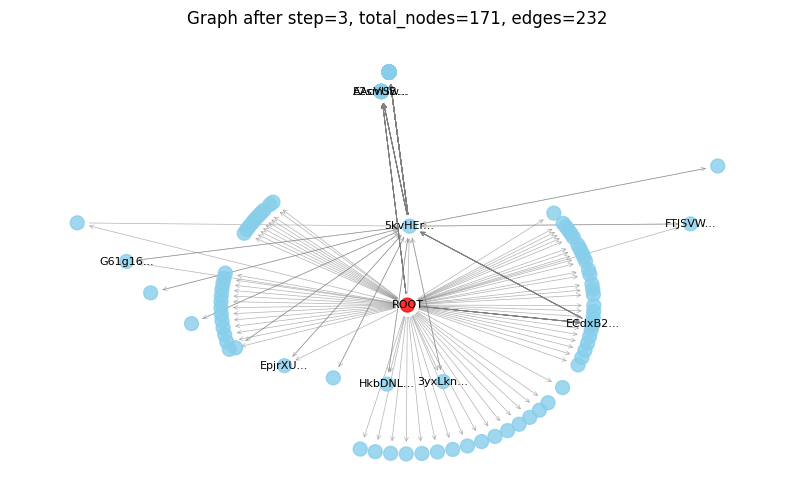

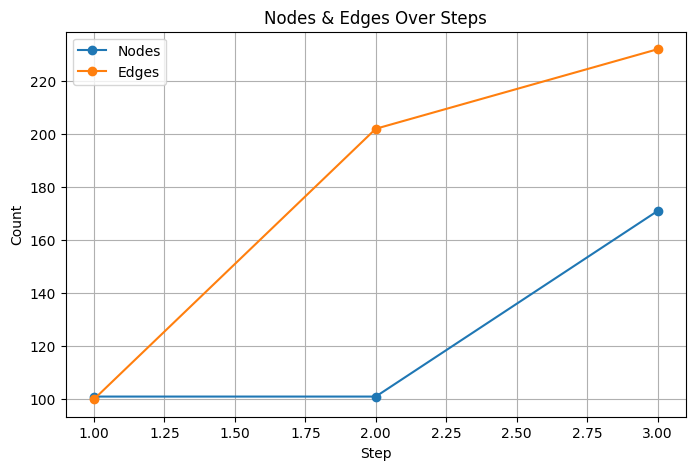

[SKIP] step_4.json found => skip scraping step 4
[CALLBACK] Step=4, total_nodes=171, frontier=87


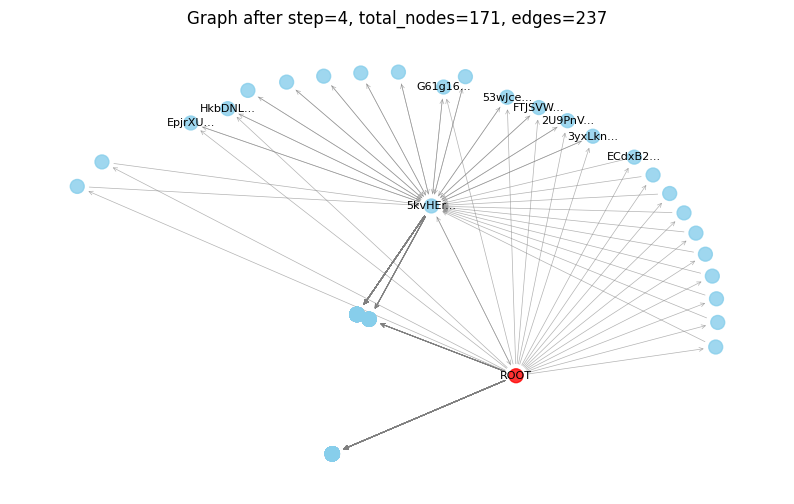

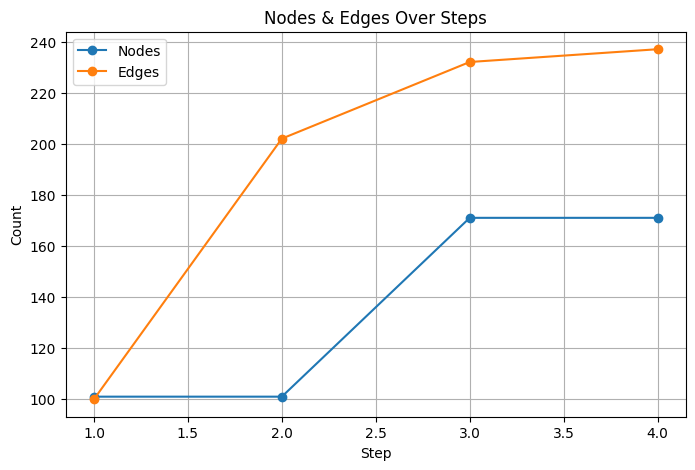

In [56]:
# this call runs the scraper and calls step_callback at each depth
scraper.run(
    step_callback=step_callback,
    steps_folder=steps_folder
)

Total nodes: 190, edges: 237
Average in-degree:  1.25
Average out-degree: 1.25


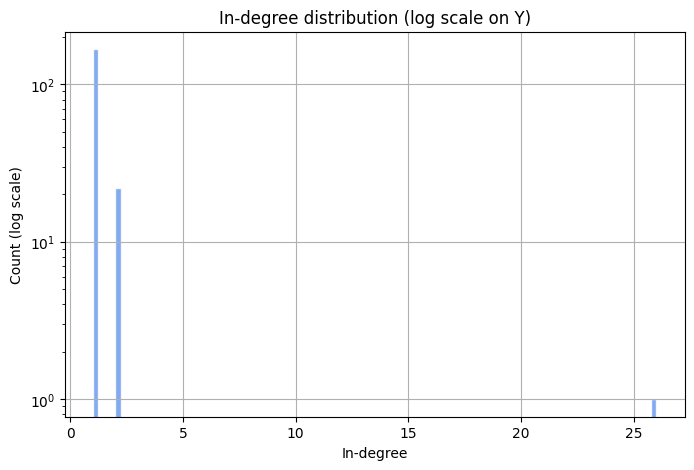

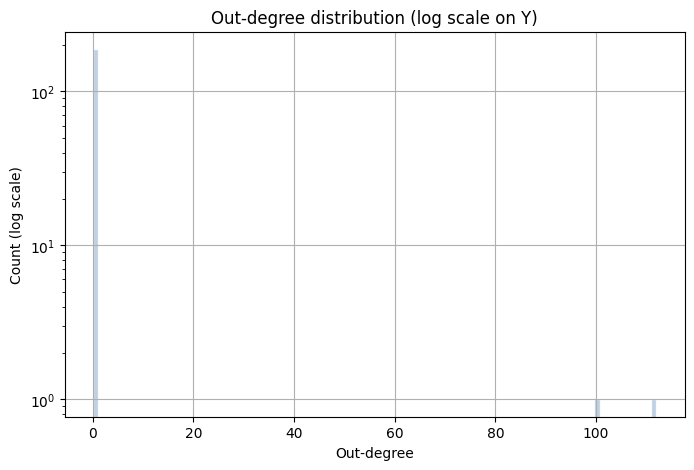

Average clustering (undirected): 0.1790
Avg shortest path length (largest WCC, undirected): 2.3098
Number of strongly connected components: 164
Largest SCC size: 27
Number of weakly connected components: 1
Largest WCC size: 190
Computing betweenness_centrality (might be slow for large graphs).
Computing closeness_centrality.
Top-5 by betweenness_centrality: [('5kvHErT7onTtJsEFxSBGxNeJCowboqmSdmQY3scLG6gA', 0.1347799166948103), ('CdwvHdpFrRKL7FW4AFD7kk7f1wuiq7fB1iE9dhbAQJXA', 0.0560058538781943), ('AD2J2NWfnpfTjpTwNvsjtmta5JZZah65RtjrprpoSPuK', 0.0), ('ECdxB2ozz6QgBgz51AQZYuFuVP1t93yjLjNvRC4vBuTg', 0.0), ('2ovRicLdxGe4H4a8ZLfo3F14TSDXKyojFX2hzCmnUhis', 0.0)]
Top-5 by closeness_centrality:   [('5kvHErT7onTtJsEFxSBGxNeJCowboqmSdmQY3scLG6gA', 0.13756613756613756), ('AAcVUBiq8vniejuyKFEGFjWQRp5Vki83yZganMWgo4z4', 0.07417582417582418), ('E2smSwAKkXM2BKBh3qU5AcAuewZrpWv4zb4Ppr459pcB', 0.07417582417582418), ('7w6WqcwBcH1ioccXdc3XzaAt8dG7YpRCtZFqujyWjFDW', 0.07417582417582418), ('9ZGgezCYzyrRUd

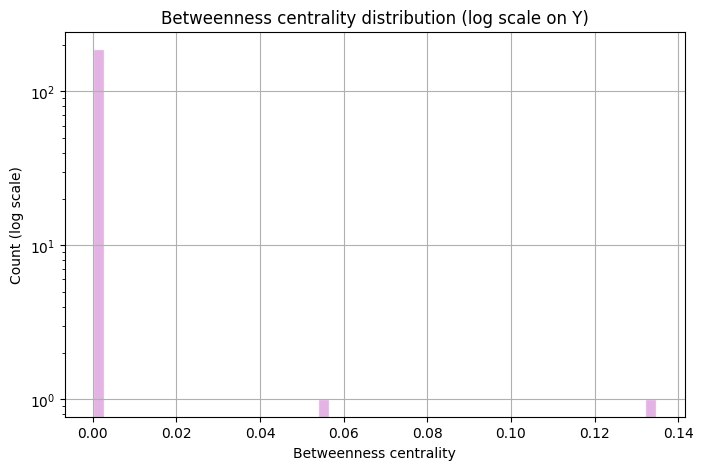

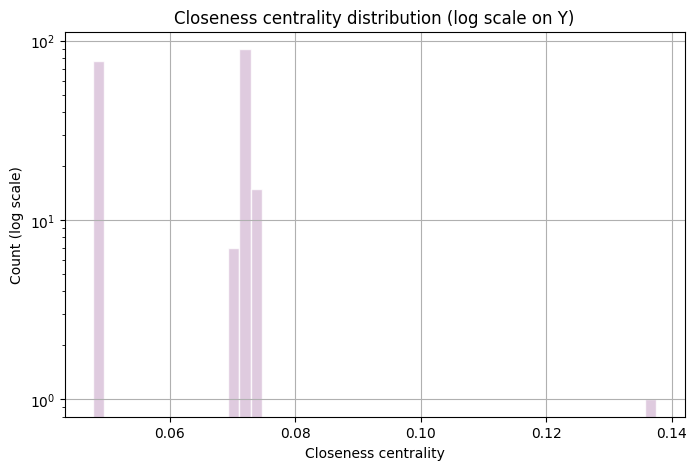

Degree Pearson correlation (out->in) = -0.9653
Rich-club coefficient (un-normalized):
 k=0: phi=0.01241993873572821
 k=1: phi=0.10952380952380952
 k=2: phi=1.0
 k=3: phi=1.0
 k=4: phi=1.0
 k=5: phi=1.0
 k=6: phi=1.0
 k=7: phi=1.0
 k=8: phi=1.0
 k=9: phi=1.0


In [57]:
# finally, we analyze the full graph
analyze_final_graph(root=scraper.root)

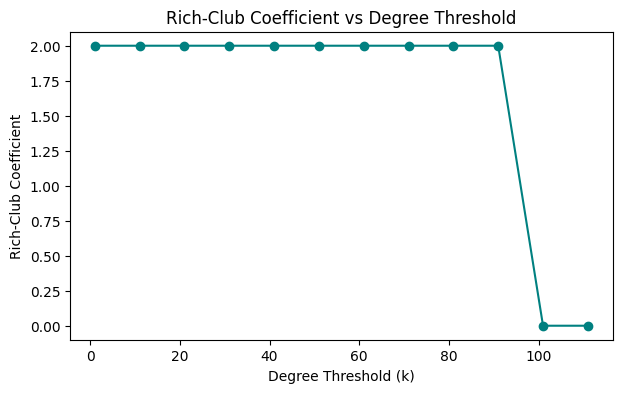

In [58]:
def rich_club_coefficient(G, k):
    nodes_high_degree = [n for n, d in G.out_degree() if d > k]
    if len(nodes_high_degree) < 2:
        return 0
    subgraph = G.subgraph(nodes_high_degree)
    edges = subgraph.number_of_edges()
    possible_edges = len(nodes_high_degree) * (len(nodes_high_degree) - 1)
    return 2 * edges / possible_edges if possible_edges > 0 else 0

G = get_final_nx_graph(scraper.root)

k_values = range(1, max([d for _, d in G.out_degree()]) + 1, 10)
rich_club = {k: rich_club_coefficient(G, k) for k in k_values}
plt.figure(figsize=(7, 4))
plt.plot(list(rich_club.keys()), list(rich_club.values()), marker='o', color="teal")
plt.xlabel("Degree Threshold (k)")
plt.ylabel("Rich-Club Coefficient")
plt.title("Rich-Club Coefficient vs Degree Threshold")
plt.show()